In [8]:
import numpy as np
from tensorflow import keras
import cv2

2023-11-02 05:04:06.835652: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 05:04:06.866084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 05:04:06.866543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 05:04:07.390256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
frames_shape = (240, 320, 3)

In [17]:
# Encoder (resnet50)
model_encoder = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=frames_shape,
)
model_encoder.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 326, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [19]:
frames_shape_encoded = model_encoder.output_shape[1:]
frames_shape_encoded

(8, 10, 2048)

In [21]:
status_frames_count = 4
frames_shape_encoded_with_status = (status_frames_count, *frames_shape_encoded)
frames_shape_encoded_with_status

(4, 8, 10, 2048)

In [61]:
# cantidad de acciones
n_actions = 11
# actiones_disponibles
actions_float = np.linspace(-.5, .5, n_actions)
actions_float

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

In [62]:
# actiones_disponibles (one hot vector)
actions_one_hot = np.eye(n_actions)
actions_one_hot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [63]:
# My Q NET
def build_net() -> keras.models.Model:
    status_input = keras.layers.Input(shape=frames_shape_encoded_with_status, name='status_input')
    status_flatten = keras.layers.Flatten(name='status_flatten')(status_input)
    status_zip = keras.layers.Dense(20, name='status_zip')(status_flatten)
    action_input = keras.layers.Input(shape=(n_actions,), name='action_input')
    action_zip = keras.layers.Dense(20, name='action_zip')(action_input)
    action_status = keras.layers.Concatenate(name='concatenate_action_status')([status_zip, action_zip])
    general_layer_output = keras.layers.Dense(1, name='q')(action_status)

    return keras.models.Model(
        name='MY_Q_NET',
        inputs=[status_input, action_input],
        outputs=[general_layer_output],
    )


general_net: keras.models.Model = build_net()
general_net.compile(optimizer='adam', loss='mean_squared_error')
general_net.summary()

Model: "MY_Q_NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 status_input (InputLayer)      [(None, 4, 8, 10, 2  0           []                               
                                048)]                                                             
                                                                                                  
 status_flatten (Flatten)       (None, 655360)       0           ['status_input[0][0]']           
                                                                                                  
 action_input (InputLayer)      [(None, 11)]         0           []                               
                                                                                                  
 status_zip (Dense)             (None, 20)           13107220    ['status_flatten[0][0]']  

In [69]:
def get_q(frames_, a: int):
    _action = actions_one_hot[a]
    # obtener los ultimos 4 frames
    _status = frames_[-4:]
    # codificar los frames
    _status_encoded = model_encoder.predict(_status)
    # obtener el Q
    prediction = general_net.predict([
        np.expand_dims(_status_encoded, axis=0),
        np.expand_dims(_action, axis=0)
    ])
    q = prediction[0][0]
    return q

In [70]:
# cargar 4 frames de prueba
frames = []
for i in range(4):
    _f = keras.preprocessing.image.load_img("frame%d.jpg" % i, target_size=(240, 320))
    frames.append(_f)

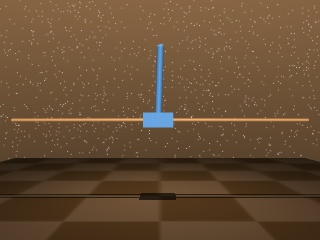

In [71]:
frames[0]

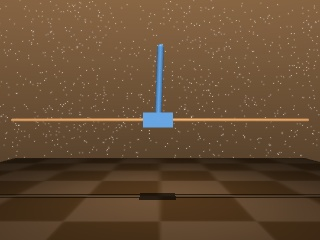

In [72]:
frames[3]

In [73]:
frames_to_array = np.array([keras.preprocessing.image.img_to_array(_f) for _f in frames])
frames_to_array.shape

(4, 240, 320, 3)

In [74]:
# obtener el Q de la accion 0
get_q(frames_to_array, 0)

1/1 [==============================] - 0s 16ms/step


1.2864934

In [ ]:
#@title Loading and simulating a `suite` task{vertical-output: true}

# Load the environment
random_state = np.random.RandomState(42)
#env = suite.load('hopper', 'stand', task_kwargs={'random': random_state})
env = suite.load('cartpole', 'balance', task_kwargs={'random': random_state})
#env = suite.load('finger', 'spin', task_kwargs={'random': random_state})
#env = suite.load('cheetah', 'run', task_kwargs={'random': random_state})

# Simulate episode with random actions
duration = 1  # Seconds
frames = []
ticks = []
rewards = []
observations = []

spec = env.action_spec()
time_step = env.reset()

actiones_disponibles = np.linspace(-.5, .5, 9)
i = 0
while env.physics.data.time < duration:
    action = np.random.choice(actiones_disponibles)
    print("Action: ", action)
    time_step = env.step(action)
    print("Position: ", time_step.observation['position'])
    print("Velocity: ", time_step.observation['velocity'])
    print("Reward: ", time_step.reward)

    camera0 = env.physics.render(camera_id=0)
    print("camera0.shape")
    print(camera0.shape)
    # Save frame has file
    cv2.imwrite("frame%d.jpg" % i, camera0)

    frames.append(camera0)
    rewards.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    ticks.append(env.physics.data.time)

    i += 1

html_video = display_video(frames, framerate=1. / env.control_timestep())

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel('reward')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
    data = np.asarray([observations[j][key] for j in range(len(observations))])
    ax[i + 1].plot(ticks, data, label=key)
    ax[i + 1].set_ylabel(key)

html_video